# Azure ML demonstration : experimentation

                                     

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Removing warnings for deprecated features etc
import warnings
warnings.filterwarnings("ignore")

## Set up Azure ML workspace connection 

In [3]:
from arcus.azureml.environment.aml_environment import AzureMLEnvironment
from arcus.ml.images import explorer

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (azureml-core 1.36.0.post2 (/usr/local/lib/python3.8/site-packages), Requirement.parse('azureml-core~=1.12.0'), {'azureml-telemetry'}).


In [4]:
training_name = 'mnist-logistic-regression'
experiment_name = 'bldstf'

In [5]:
azure_config_file = '.azureml/config.json'
aml = AzureMLEnvironment.Create(config_file=azure_config_file)

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Connected to AzureML workspace
>> Name: savanh-ml-ops
>> Subscription: b73995e3-caad-4882-8644-f2175789c3ff
>> Resource group: azure-mlops


## MNIST classification
De MNIST ("Modified National Institute of Standards and Technology") is a dataset that is being used a lot to measure and benchmark different classification algorithms.  The dataset contains 10's thousands of images of handwritten numbers.  More information can be found here: http://yann.lecun.com/exdb/mnist/


### Load data

In [6]:
aml_df = aml.load_tabular_dataset('mnist')


In [7]:
aml_df.shape

(42000, 785)

In [8]:
training_set_size = 1000
test_set_size = 250
scoring_parameter = "accuracy"
decision_function_shape = "ovr"

df = aml_df.copy()

In [9]:
#Inlezen van de dataset en de trainingsgrootte bepalen
if(training_set_size > 0 and test_set_size > 0):
    df = df.sample(n=training_set_size + test_set_size)

y = df.label.values # The label is what we should predict = the y in the equation
X = np.asarray(df.drop(['label'],axis=1))


In [10]:
if test_set_size <= 0: 
    test_set_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=42)

In [11]:
print(f'Train records: {len(X_train)}')
print(f'Test records: {len(X_test)}')
print(f'Input features: {X_train.shape[1]}')

Train records: 1000
Test records: 250
Input features: 784


## Data demonstration

7


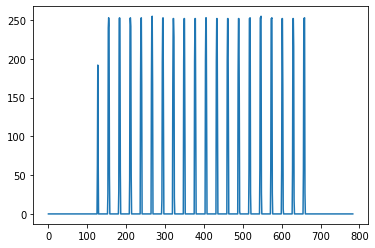

In [75]:
sample_image = X[31].reshape(28,28)

print(y[31])
plt.plot(X[1])
plt.show()

In [13]:
str_array = ''
for b in X[2]:
    str_array += f'{b},'

print(str_array)

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,209,175,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,152,249,249,249,253,254,255,241,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,96,220,246,254,254,231,52,33,59,105,254,235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,145,236,252,254,254,173,120,15,0,0,0,2,158,254,109,0,0,0,0,0,0,0,0,0,0,0,0,213,252,254,221,116,25,6,0,0,0,0,0,61,191,254,117,0,0,0,0,0,0,0,0,0,0,0,0,236,219,116,21,0,0,0,0,0,0,0,77,242,254,250,75,0,0,0,0,0,0,0,0,0,0,0,0,236,156,0,0,0,0,0,0,0,60,106,241,246,159,37,0,0,0,0,0,0,0,0,0,0,0,0,0,195,237,27,0,0,0,0,19,106,241,254,120,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76,247,162,11,0,0,56,182,254,204,95,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,254,72,95,197,241,239,162,18,0,0,0,0,0,0,0,0,0,0,0

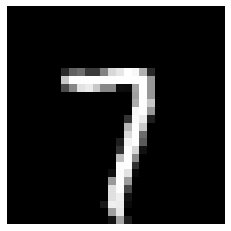

In [14]:
explorer.show_image(sample_image)

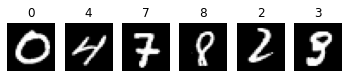

In [15]:
explorer.visualize_classes(X_train.reshape(len(X_train),28,28), y_train, image_count=6)

## Data preparation (scaling)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

## Model training, local

In [17]:
trainer = aml.start_experiment(experiment_name)

In [18]:
c_value = 0.21
_run = trainer.new_run(f'C={c_value}')
model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', C=c_value)
model.fit(X_train, y_train)


LogisticRegression(C=0.21, class_weight='balanced', multi_class='multinomial')

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        19
           1       0.90      1.00      0.95        27
           2       0.96      0.79      0.87        29
           3       0.81      0.96      0.88        23
           4       0.86      0.96      0.91        26
           5       0.92      0.82      0.87        28
           6       0.94      0.84      0.89        19
           7       0.86      0.92      0.89        26
           8       0.88      0.79      0.83        28
           9       0.88      0.88      0.88        25

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250

[[16  0  1  0  0  0  0  0  2  0]
 [ 0 27  0  0  0  0  0  0  0  0]
 [ 0  2 23  0  1  0  0  2  1  0]
 [ 0  0  0 22  0  1  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  1]
 [ 2  0  0  2  0 23  1  0  0  0]
 [ 1  0  0  0  2  0 16  0  0  0]
 [ 0  0  0

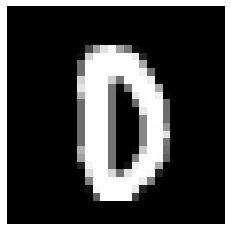

In [19]:
trainer.evaluate_image_classifier(model, X_test=X_test, y_test=y_test, failed_classifications_to_save=3, image_shape=(28,28), finish_existing_run = False, upload_model=False, save_curves_as_image=False)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        21
           1       0.73      0.94      0.82        17
           2       0.80      0.59      0.68        27
           3       0.92      0.76      0.83        29
           4       0.77      0.87      0.82        23
           5       0.73      0.73      0.73        22
           6       0.82      0.90      0.86        20
           7       0.82      0.77      0.79        35
           8       0.90      0.85      0.88        33
           9       0.71      0.87      0.78        23

    accuracy                           0.81       250
   macro avg       0.81      0.82      0.81       250
weighted avg       0.82      0.81      0.81       250

[[20  0  0  0  0  1  0  0  0  0]
 [ 0 16  1  0  0  0  0  0  0  0]
 [ 2  2 16  1  1  2  0  3  0  0]
 [ 0  1  2 22  1  1  0  1  1  0]
 [ 0  0  0  0 20  0  2  0  0  1]
 [ 0  1  0  1  0 16  1  1  2  0]
 [ 0  0  0  0  1  1 18  0  0  0]
 [ 0  2  1

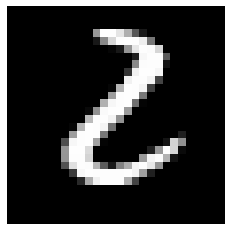

In [20]:
for c_value in [0.01, 1, 5] :
    _run = trainer.new_run(f'C={c_value}')
    model = LogisticRegression(solver='saga', C=c_value)
    model.fit(X_train, y_train)
    trainer.evaluate_image_classifier(model, X_test=X_test, y_test=y_test, failed_classifications_to_save=3, image_shape=(28,28), finish_existing_run = True, upload_model=True, save_curves_as_image=False)
    #trainer.evaluate_classifier(model, X_test, y_test, upload_model = True)

## Model training, docker

In [20]:
trainer = aml.start_experiment(experiment_name)
trainer.setup_training(training_name)

In [21]:
args = {
    '--c_value': 1.92,
    '--solver': 'lbfgs', # lbfgs newton-cg liblinear saga sag
    '--train_test_split_ratio': 0.25
}

compute_run = trainer.start_training(training_name, environment_type=None, 
                       script_parameters=args, use_estimator=True,
                       compute_target='gpu-training', gpu_compute=True)

Scheduling Estimator training


WARNING - 'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.
WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


Creating estimator of type None
https://ml.azure.com/runs/bldstf_1637077010_9fb13f72?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops&tid=37e57300-9b18-4cdd-8afa-ce7fcba873b0


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [24]:
for solver in ['lbfgs', 'newton-cg']:
    for c_value in np.logspace(0.001, 2, num=3):
        args = {
            '--c_value': c_value,
            '--solver': solver, # lbfgs newton-cg liblinear saga sag
            '--train_test_split_ratio': 0.3
        }


        compute_run = trainer.start_training(training_name, environment_type=None, 
                               script_parameters=args, use_estimator=True,
                               compute_target='gpu-training', gpu_compute=True)

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/bldstf/runs/bldstf_1637073067_10ce3e9e?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/bldstf/runs/bldstf_1637073069_5a510b7a?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/bldstf/runs/bldstf_1637073071_54152035?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/bldstf/runs/bldstf_1637073074_e3af0667?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/bldstf/runs/bldstf_1637073075_8388020d?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/bldstf/runs/bldstf_1637073077_e4366d59?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/azure-mlops/workspaces/savanh-ml-ops


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Deploy ML Model

In [44]:
model_name = 'mnist'
env_name = 'mnist'

In [24]:
from azureml.core import Run

def deploy_model(experiment, run_name, model_location):
    for run in experiment.get_runs():
        if(run.display_name==run_name):
            model = run.register_model(model_name=model_name,
                           tags={'output': 'number', 'input': 'mnistarray'},
                           model_path=model_location)
            print(model.name, model.id, model.version, sep='\t')
            break
    
deploy_model(trainer._AzureMLTrainer__experiment, 'willing_berry_cpbmlgzd', 'outputs/model.sav')

mnist	mnist:1	1


In [25]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=model_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='savanh-ml-ops', subscription_id='b73995e3-caad-4882-8644-f2175789c3ff', resource_group='azure-mlops'), name=mnist, id=mnist:1, version=1, tags={'output': 'number', 'input': 'mnistarray'}, properties={})


In [26]:
Model.get_model_path(training_name)

'mnist-logistic-regression'

## Set up inference cluster

In [45]:
envs = Environment.list(workspace=aml.get_azureml_workspace())

myenv = Environment.from_pip_requirements(name = env_name,
                                          file_path = f"{training_name}/requirements.txt")
myenv.docker.enabled = True
myenv.register(workspace=aml.get_azureml_workspace())

WARNING - 'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20211029.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "mnist",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
         

In [46]:
web_service_name= training_name.lower() + '-v4'

In [47]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1, 
                                                       auth_enabled=True, enable_app_insights=True)
deployment_target = None

In [49]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
myenv = Environment.get(aml.get_azureml_workspace(), env_name)
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

In [50]:
from azureml.core import Environment
from azureml.core.webservice import Webservice
from azureml.exceptions import ComputeTargetException, WebserviceException

try:
    service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())
    print('Web service exists and retrieved')
except WebserviceException:
    print('Deploying model as web service')
    service = Model.deploy(workspace=aml.get_azureml_workspace(), 
                           name=web_service_name, 
                           models=[series_model], 
                           deployment_target=deployment_target,
                           inference_config=inference_config, 
                           deployment_config=deployment_config)
    service.wait_for_deployment(show_output=True)
    print(service.state)
    service.get_logs()    
    print('Web service created')

Deploying model as web service
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-11-16 18:14:03+02:00 Creating Container Registry if not exists.
2021-11-16 18:14:04+02:00 Registering the environment.
2021-11-16 18:14:05+02:00 Building image..
2021-11-16 18:19:16+02:00 Generating deployment configuration.
2021-11-16 18:19:17+02:00 Submitting deployment to compute..
2021-11-16 18:19:23+02:00 Checking the status of deployment mnist-logistic-regression-v4..
2021-11-16 18:21:01+02:00 Checking the status of inference endpoint mnist-logistic-regression-v4.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
Web service created


## Update scoring script

In [52]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
myenv = Environment.get(aml.get_azureml_workspace(), env_name)
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

In [53]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())

In [55]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=model_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='savanh-ml-ops', subscription_id='b73995e3-caad-4882-8644-f2175789c3ff', resource_group='azure-mlops'), name=mnist, id=mnist:1, version=1, tags={'output': 'number', 'input': 'mnistarray'}, properties={})


In [56]:
service.update(models=[series_model], inference_config=inference_config, enable_app_insights=True)

In [57]:
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-11-16 18:27:06+02:00 Creating Container Registry if not exists.
2021-11-16 18:27:07+02:00 Registering the environment.
2021-11-16 18:27:07+02:00 Use the existing image.
2021-11-16 18:27:08+02:00 Generating deployment configuration.
2021-11-16 18:27:09+02:00 Submitting deployment to compute.
2021-11-16 18:27:12+02:00 Checking the status of deployment mnist-logistic-regression-v4..
2021-11-16 18:31:26+02:00 Checking the status of inference endpoint mnist-logistic-regression-v4.
Succeeded
ACI service creation operation finished, operation "Succeeded"


## Execute service call

In [63]:
#print(service.get_keys())
print(service.scoring_uri)

http://76f55001-6e1e-4dea-8792-09a7400b3797.westeurope.azurecontainer.io/score


In [76]:
import requests
import json

headers = {'Content-Type': 'application/json'}

headers['Authorization'] = 'Bearer '+service.get_keys()[0]
request_data = np.array([X[31].tolist()])
print(request_data.shape)
#print(request_data.shape)

response = requests.post(
    service.scoring_uri, data=json.dumps({'data': request_data.tolist()}), headers=headers)
print(f'Status: {response.status_code}')
print(f'Call duration: {response.elapsed}')

if(response.ok):
    results = response.json()
    print(results)
else:
    print(service.get_logs().splitlines()) 

(1, 784)
Status: 200
Call duration: 0:00:00.119798
[5]


In [ ]:
X[31]